### Activate the auto-reload

In [1]:
%load_ext autoreload
%autoreload 2

### Import the libraries

In [2]:
import sys
from pathlib import Path
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf

### Set file path to parent directory

In [3]:
sys.path.append(str(Path().resolve().parent / "src"))
os.chdir("../")

### Import the homemade functions

In [4]:
from src.data.data_import import DataImporter
from src.features.generate_features import GenerateFeatures

/Users/nakamurahanako/Documents/GitHub/graspp-25S-trade/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


### Get the API keys to access UN data

How-to available at this address: [https://uncomtrade.org/docs/api-subscription-keys/](https://uncomtrade.org/docs/api-subscription-keys/)

In [8]:
UN_API_KEY = "1b9e65d70d9f4e1c8323548618cf877f"

# 1. Import the data

In [9]:
importer = DataImporter(api_key=UN_API_KEY)
df = importer.get_merged_data()
df.head(2)

100%|██████████| 4/4 [00:17<00:00,  4.44s/it]
/Users/nakamurahanako/Documents/GitHub/graspp-25S-trade/src/data/data_import.py:92: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(list_df)


Saving the dataset to: /Users/nakamurahanako/Documents/GitHub/graspp-25S-trade/data/external/trade_raw.csv
Saving the dataset to: /Users/nakamurahanako/Documents/GitHub/graspp-25S-trade/data/interim/trade_clean.csv
Fetching ILO data from: https://rplumber.ilo.org/data/indicator/?id=EMP_TEMP_ECO_OCU_NB_A&timefrom=2000&timeto=2024&classif1=ECO_SECTOR_IND&classif2=OCU_SKILL_TOTAL&format=.csv
Saving the dataset to: /Users/nakamurahanako/Documents/GitHub/graspp-25S-trade/data/external/employment_raw.csv
Saving the dataset to: /Users/nakamurahanako/Documents/GitHub/graspp-25S-trade/data/interim/employment_clean.csv
Saving the dataset to: /Users/nakamurahanako/Documents/GitHub/graspp-25S-trade/data/interim/merge.csv


,,Export,Import,ILO
country,year,,,
ABW,2010,124523218.0,1.071034e+09,6.738
AFG,2014,570534007.0,7.697178e+09,1389.950


# 2. Descriptive Statistics

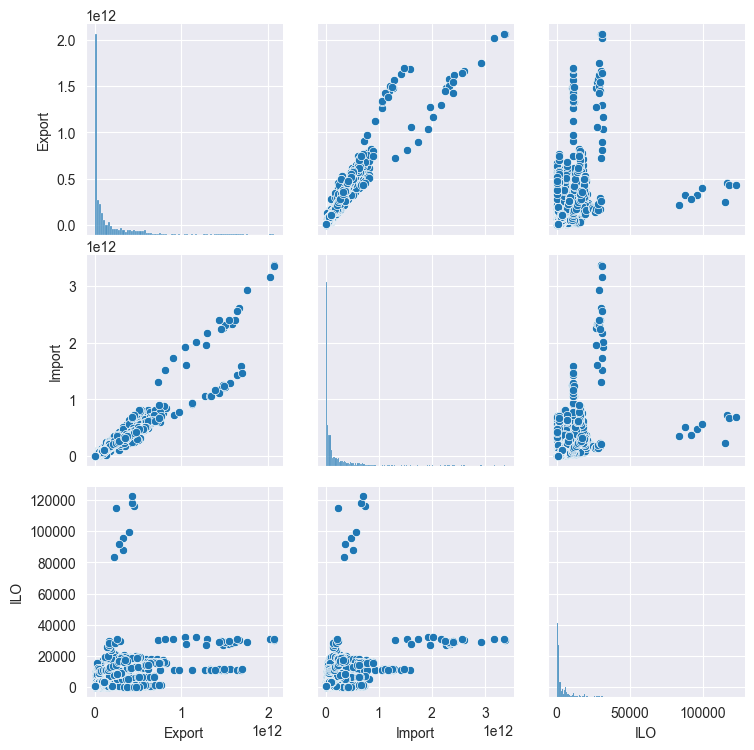

In [ ]:
g = sns.PairGrid(df)
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)

# 3. Conducting Regression Analysis - Wanonno Iqtyider

                            OLS Regression Results                            
Dep. Variable:            Q("Export")   R-squared:                       0.189
Model:                            OLS   Adj. R-squared:                  0.189
Method:                 Least Squares   F-statistic:                     444.4
Date:                Fri, 23 May 2025   Prob (F-statistic):           7.74e-89
Time:                        13:48:32   Log-Likelihood:                -52566.
No. Observations:                1906   AIC:                         1.051e+05
Df Residuals:                    1904   BIC:                         1.051e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   9.378e+10   5.68e+09     16.519      0.0

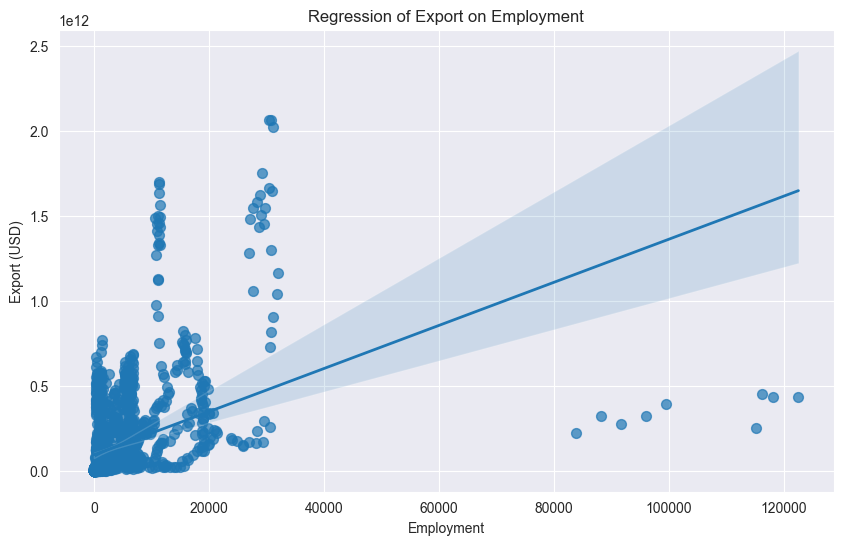

In [ ]:
# 2. Prepare the data
# Make sure 'employment' and 'total trade value' exist without NaNs
df_regression = df.dropna(subset=["Export", "ILO"]).reset_index()

# 3. Run the regression using formula
# Note: you need to handle spaces in column names by using `Q("column name")` inside the formula
model = smf.ols(formula='Q("Export") ~ ILO', data=df_regression).fit()

# 4. Print regression summary
print(model.summary())

plt.figure(figsize=(10,6))
sns.regplot(
    data=df_regression,
    x="ILO",
    y="Export",
    scatter_kws={"s":50, "alpha":0.7},
    line_kws={"linewidth":2}
)
plt.title('Regression of Export on Employment')
plt.xlabel('Employment')
plt.ylabel('Export (USD)')
plt.grid(True)
plt.show()


# 4. Analysis on the correlation between changes in employment and trade volume - Yijing

## 4.1 Plotting the change in employment throughout countries using ILO dataset

In [ ]:
print(df.columns)
df.head(2)

Index(['Export', 'Import', 'ILO'], dtype='object')


,,Export,Import,ILO
country,year,,,
ABW,2010,124523218.0,1.071034e+09,6.738
AFG,2014,570534007.0,7.697178e+09,1389.950


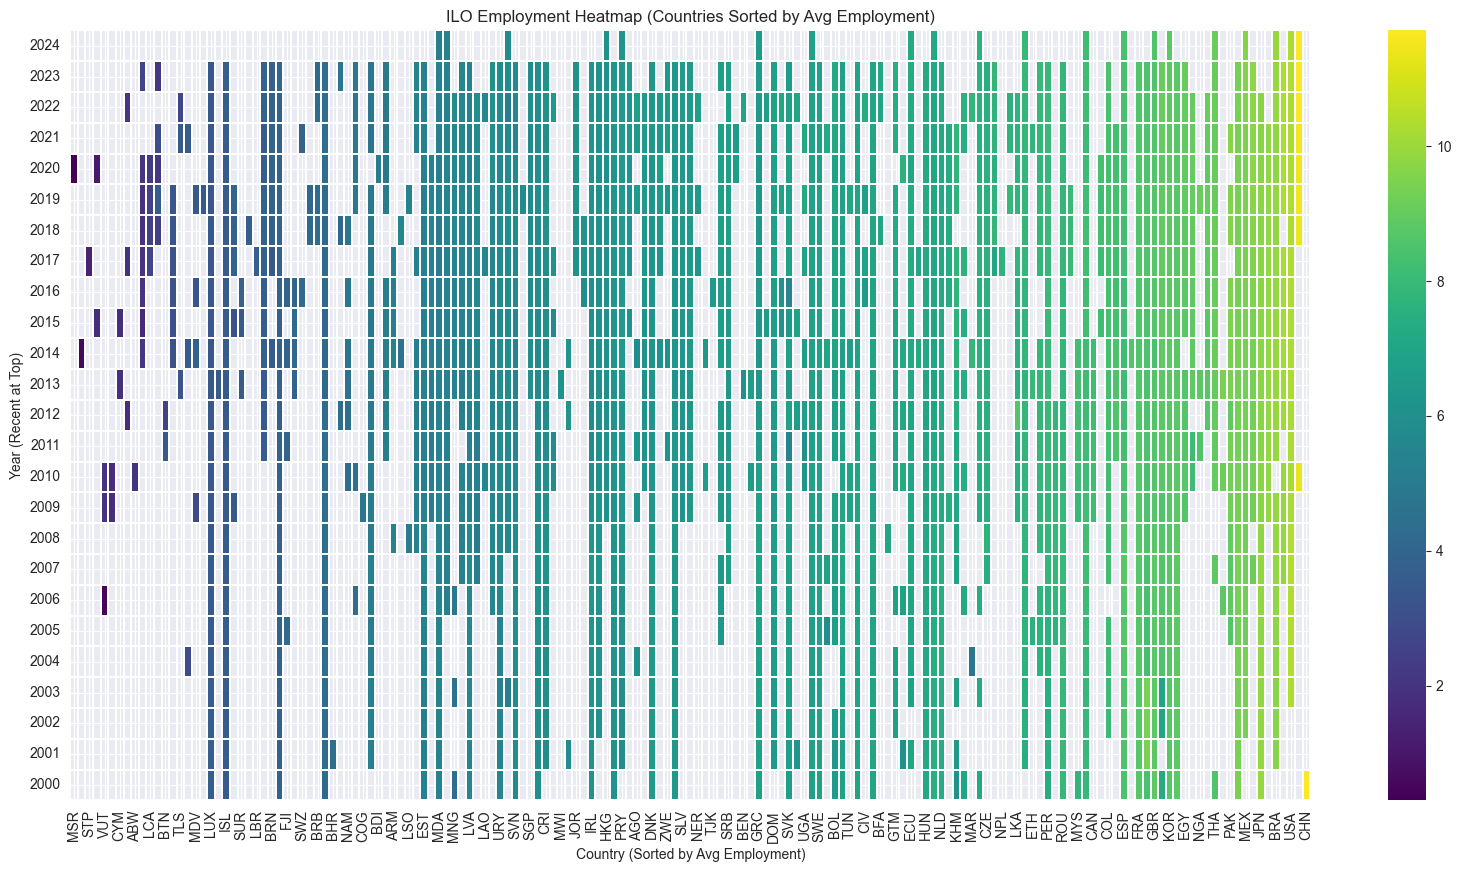

In [ ]:
# In the heatmap, countries positioned further to the right and shaded in lighter colors generally exhibit higher average employment
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df_heatmap = df['ILO'].unstack(level=0)
df_heatmap = df_heatmap.sort_index(ascending=False)

# Sort countries (columns) by average employment (low → high)
avg_employment = df_heatmap.mean(axis=0)
df_heatmap = df_heatmap[avg_employment.sort_values().index]

# Plot
plt.figure(figsize=(20, 10))
sns.heatmap(np.log1p(df_heatmap), cmap='viridis', linewidths=0.1)
plt.title("ILO Employment Heatmap (Countries Sorted by Avg Employment)")
plt.xlabel("Country (Sorted by Avg Employment)")
plt.ylabel("Year (Recent at Top)")
plt.show()

## 4.2 Regression analysis of the correlation between changes in employment and trade volume

In [ ]:
# Differ from Wanno's regression, it analyzes the relationship between year-to-year changes in employment
# and total trade volume (Export + Import, as Trade_diff), rather than using absolute values.
# Unlike the previous analysis that examined whether high employment correlates with high exports,
# this approach focuses on whether increases in trade are associated with increases in employment over time.
df['Total_Trade'] = df['Export'] + df['Import']
df_merge = df.sort_index()


In [ ]:
# Percentage changes


features_generator = GenerateFeatures(time_period="Y")
df_features = features_generator.transform(df_merge)
df_clean = df_features.dropna(subset=['ILO_chpct1Y', 'Total_Trade_chpct1Y'])

/Users/quentin/Documents/Development/graspp-25S-trade/src/features/generate_features.py:73: FutureWarning: The default fill_method='ffill' in DataFrameGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df_pct_change = group_obj[num_cols].pct_change().add_suffix(f'_chpct1{self.time_period}')


In [ ]:
correlation = df_clean['ILO_chpct1Y'].corr(df_clean['Total_Trade_chpct1Y'])
print("Correlation between percentage change in employment and trade volume:", correlation)


Correlation between percentage change in employment and trade volume: 0.189580049342669


Text(0.5, 1.0, 'Regression Analysis of Employment and Trade Volume Changes')

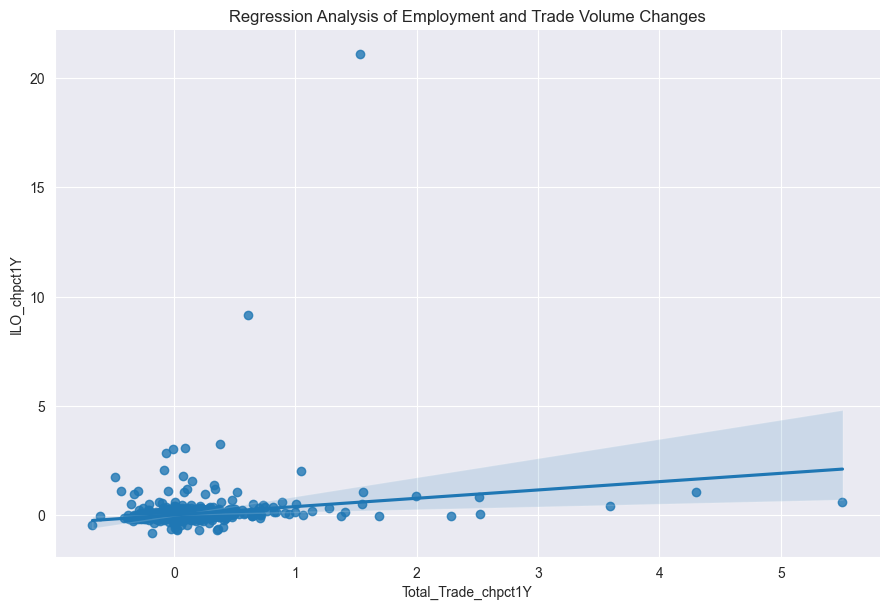

In [ ]:
import seaborn as sns
sns.lmplot(x='Total_Trade_chpct1Y', y='ILO_chpct1Y', data=df_clean, height=6, aspect=1.5)
plt.title("Regression Analysis of Employment and Trade Volume Changes")
# Interpretation: When a country's total trade volume increases, its employment tends to increase, on average.

## 4.3 Histogram for percentage change in employment and trade

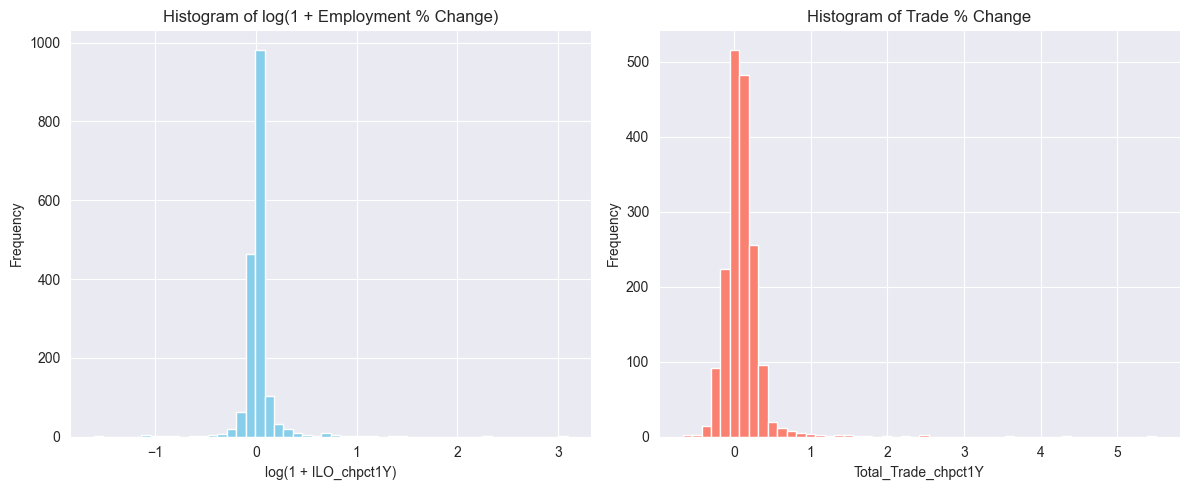

In [ ]:
# Plot histogram for percentage change in employment
# I use log for pct change in employment to reduce the effect of extreme values as the distribution without log was heavily right-skewed

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(np.log1p(df_clean['ILO_chpct1Y']), bins=50, color='skyblue')
plt.title("Histogram of log(1 + Employment % Change)")
plt.xlabel("log(1 + ILO_chpct1Y)")
plt.ylabel("Frequency")

# Plot histogram for percentage change in trade
plt.subplot(1, 2, 2)
plt.hist(df_clean['Total_Trade_chpct1Y'], bins=50, color='salmon')
plt.title("Histogram of Trade % Change")
plt.xlabel("Total_Trade_chpct1Y")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()